# Now we start to have fun with a combo model

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# get pandas
import pandas as pd
# we'll do some visual checks, get the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [6]:
# get the input df
df_raw = pd.read_csv('../data/train.csv')

In [7]:
# wrapper function to perform some simple cleanup
def clean_df(df):
    # drop everything with more than 10% of missing values
    df = df[df.columns[df.isnull().mean() < 0.1]]
    # looks like Garage built goes with Year built, replace NA using that
    df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt'] = df['YearBuilt']
    # put zero for MasVnrArea
    df.loc[df['MasVnrArea'].isnull(),'MasVnrArea'] = 0.0
    # drop id
    df = df.drop(['Id'], axis=1)    
    # remove outliers
    df = df[df['GrLivArea'] < 4676] 
    # make sure categorical variables are always filled
    df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
    return df

In [8]:
df = clean_df(df_raw)

In [10]:
# now make all the transformations for cats, plus save the dictionary
# some tests with LabelEncoder

from sklearn import preprocessing 
from collections import defaultdict

def cat_handler_df(df):
    # get list of categorical variables
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    # prep the dictionary
    d = defaultdict(preprocessing.LabelEncoder)
    # Encoding the variables
    df[cat_cols] = df[cat_cols].apply(lambda x: d[x.name].fit_transform(x))
    # return the df and the dictionary
    return df, d

In [11]:
(df,cat_dic) = cat_handler_df(df)

In [14]:
# now we will look at the variable ranking with a different approach, GBT
from sklearn import ensemble
# prep scikit
input_features = list(df.columns)
input_features.remove('SalePrice')
X = df[input_features].values
y = np.log(df['SalePrice']+1).values

## first let's get a model baseline

In [15]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

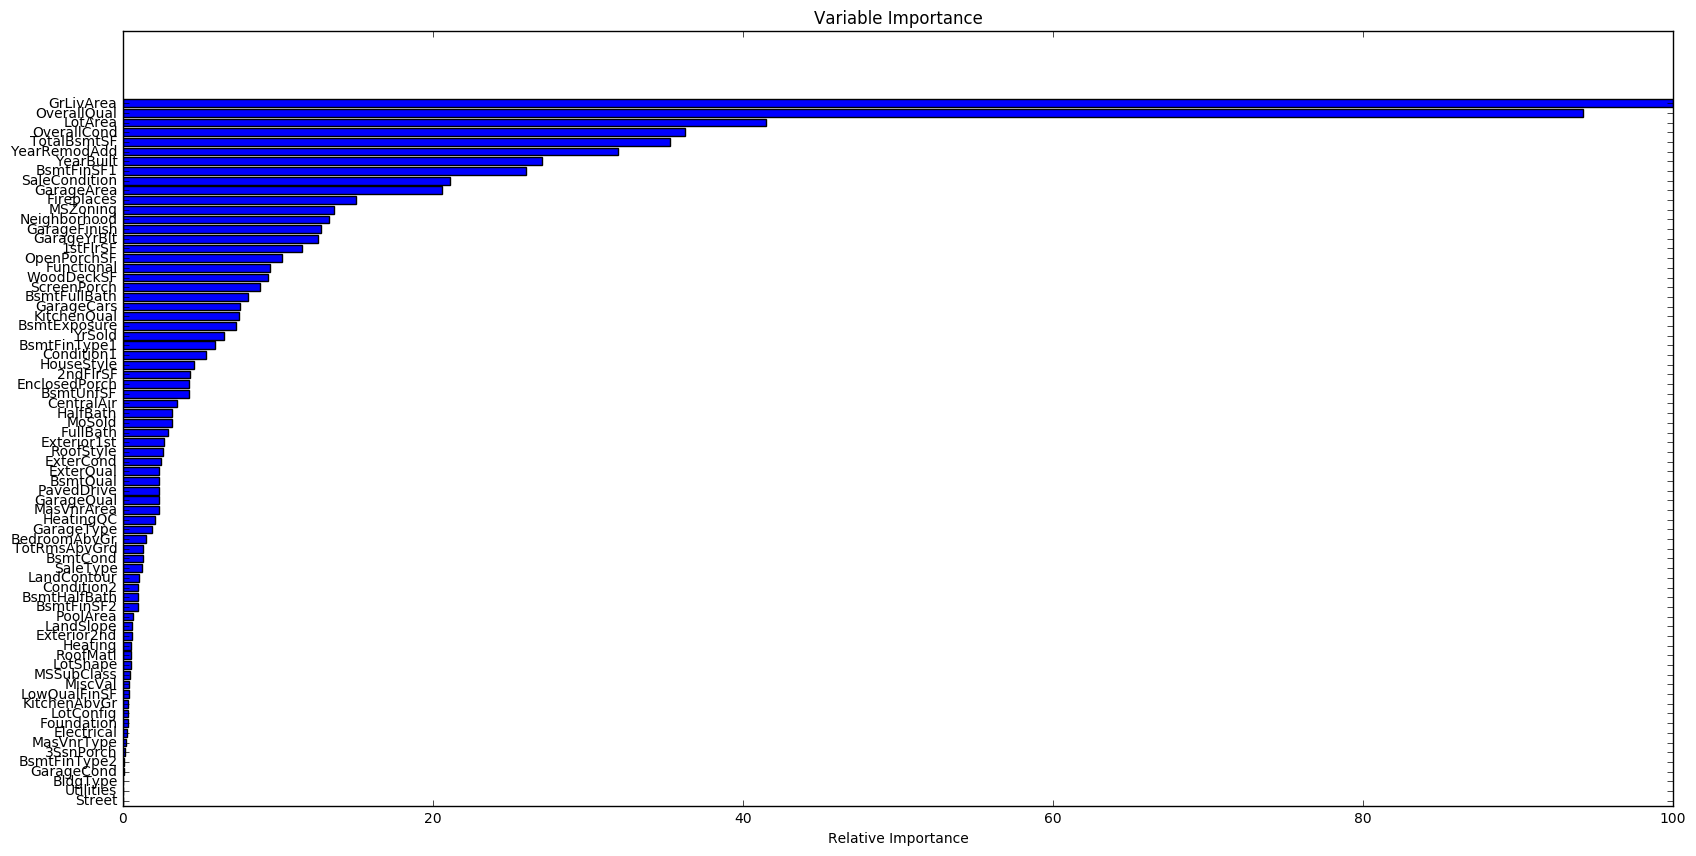

In [18]:
# have a look at the plot
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [input_features[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [19]:
# create score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
def my_function(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

custom_scorer = make_scorer(my_function, greater_is_better=False)

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=3, scoring=custom_scorer)
print("Mean Squared Error (on Log): %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Mean Squared Error (on Log): -0.129 (+/- 0.014)


In [23]:
# now we will perform some simple model tuning
from sklearn.model_selection import GridSearchCV

In [24]:
# simple test to check machinery
params_grid = {
    'n_estimators': [600], 
    'max_depth': [4], 
    'min_samples_split': [2],#20
    'learning_rate': [0.01*2],#0.01
    'loss': ['ls'],
    'criterion': ['friedman_mse'],
    'min_samples_leaf': [3],
    'max_features': ['log2'],#auto,
    'warm_start': [False],#true
}

gs_clf = GridSearchCV(clf, params_grid, 
                      n_jobs=-1, cv=3,
                      scoring=custom_scorer)
gs_clf.fit(X, y)

print("Best parameters set found on development set:")
print()
print(gs_clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = gs_clf.cv_results_['mean_test_score']
stds = gs_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'learning_rate': 0.02, 'n_estimators': 600, 'criterion': 'friedman_mse', 'loss': 'ls', 'warm_start': False, 'min_samples_split': 2, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3}

Grid scores on development set:

-0.119 (+/-0.017) for {'learning_rate': 0.02, 'n_estimators': 600, 'criterion': 'friedman_mse', 'loss': 'ls', 'warm_start': False, 'min_samples_split': 2, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3}


In [25]:
# looks good, redo the model
params = {'max_depth': 4, 'criterion': 'friedman_mse', 'min_samples_split': 2, 'n_estimators': 600, 'max_features': 'log2', 'min_samples_leaf': 3, 'loss': 'ls', 'warm_start': False, 'learning_rate': 0.02}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=3, scoring=custom_scorer)
print("Mean Squared Error (on Log): %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Mean Squared Error (on Log): -0.118 (+/- 0.017)


In [26]:
# looks good save the model
import pickle
pickle.dump(clf, open('../models/gbt_combo_reg_v1.pkl', 'wb'))

In [27]:
# remember to save the dictionary
pickle.dump(cat_dic, open('../models/gbt_combo_dic_v1.pkl', 'wb'))